In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import time
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from matplotlib.colors import LogNorm
from scipy.signal import convolve as scipy_convolve
from matplotlib import gridspec

In [2]:
def int_spec(mini_cube,mini_err):
    shape = mini_cube.shape[1]*mini_cube.shape[2]
    int_spectrum = sum(mini_cube[:,i,j] for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2]))
    int_error = np.sqrt(sum((mini_err[:,i,j])**2 for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2])))
    return int_spectrum,int_error

def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Hb_O3_gauss(wave,amp_Hb,amp_OIII5007,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    OIII_4959 = (0.33)*gauss(wave,amp_OIII5007,vel,vel_sigma,4958.9)
    OIII_5007 = gauss(wave,amp_OIII5007,vel,vel_sigma,5006.8)
    return Hb + OIII_4959 + OIII_5007

def Hb_Fe_doublet_gauss(wave,amp_Hb,amp_Fe5018,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    Fe_4923 = 0.81*gauss(wave,amp_Fe5018,vel,vel_sigma,4923)
    Fe_5018 = gauss(wave,amp_Fe5018,vel,vel_sigma,5018)
    return Hb+Fe_4923+Fe_5018

def full_gauss2(p,wave,data,error):
    (amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,amp_Hb_br,amp_OIII5007_br,vel_wing,vel_wing_sigma,amp_Hb1,amp_Fe5018_1,amp_Hb2,amp_Fe5018_2,m,c)=p
    narrow_OIII1 = Hb_O3_gauss(wave,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma)
    narrow_OIII2 = Hb_O3_gauss(wave,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma)
    broad_OIII = Hb_O3_gauss(wave,amp_Hb_br,amp_OIII5007_br,vel_wing,vel_wing_sigma)
    Hb_broad1 = Hb_Fe_doublet_gauss(wave,amp_Hb1,amp_Fe5018_1,vel_core,vel_core_sigma) 
    Hb_broad2 = Hb_Fe_doublet_gauss(wave,amp_Hb2,amp_Fe5018_2,vel_core,vel_core_sigma) 
    cont = (wave/1000.0)*m+c
    return (narrow_OIII1+narrow_OIII2+broad_OIII+Hb_broad1+Hb_broad2+cont-data)/error

def full_gauss3(p,wave,data,error):
    (amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c)=p
    narrow_OIII1 = Hb_O3_gauss(wave,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma)
    broad_OIII = Hb_O3_gauss(wave,amp_Hb_2,amp_OIII50072,vel_wing,vel_wing_sigma) 
    cont = (wave/1000.0)*m+c
    return (narrow_OIII1+broad_OIII+cont-data)/error

In [3]:
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']  # central wavelength = CDELT3 is microns per pixel. 
wavint = qso_header['CD3_3']  # wavelength interval
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
#[central_x,central_y]= [55,58]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

In [4]:
z = 0.02172
k = 1+z
c = 300000
central_vel = c*z

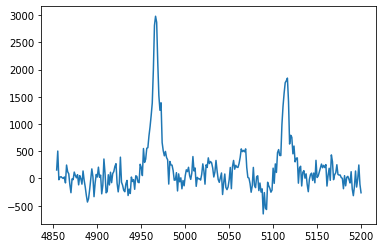

In [5]:
wave = np.arange(wavestart,(wavestart+(wavint*qso_data.shape[0])),wavint)#start,stop,step
select =(wave>4750*k)&(wave<5090*k)
x0 = 55
y0 = 58
x = wave[select]
data = qso_data[:,y0-1:y0+2,x0-1:x0+2][select]
data_err = qso_error[:,y0-1:y0+2,x0-1:x0+2][select]
(y,y_err) = int_spec(data,data_err) 
plt.plot(x,y)
plt.show()

In [6]:
# lower_bounds = [0,0,central_vel - 1000,0,-np.inf,-np.inf]
# upper_bounds = [np.inf,np.inf,central_vel + 1000,1000,np.inf,np.inf]
# bounds_p_init = (lower_bounds,upper_bounds) 

# result = least_squares(full_gauss3,x0=[300,150,6516,100,-0.001,0.1],bounds=bounds_p_init,args = (x,y,y_err),max_nfev=10000000)
# popt = result['x']  
# print(popt)

In [7]:
popt,pcov = leastsq(full_gauss3,x0=[300,150,330,175,6516,100,6496,200,-0.001,0.1],args=(x,y,y_err),maxfev = 10000000)                                                    
print(popt)
[amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c] = popt

[1527.34814545 1039.34742556 1478.49818225  891.99527943 6490.30564333
  115.17488468 6511.00384837  412.73347644  122.11409763 -621.25330208]


Text(0, 0.5, 'Residuals')

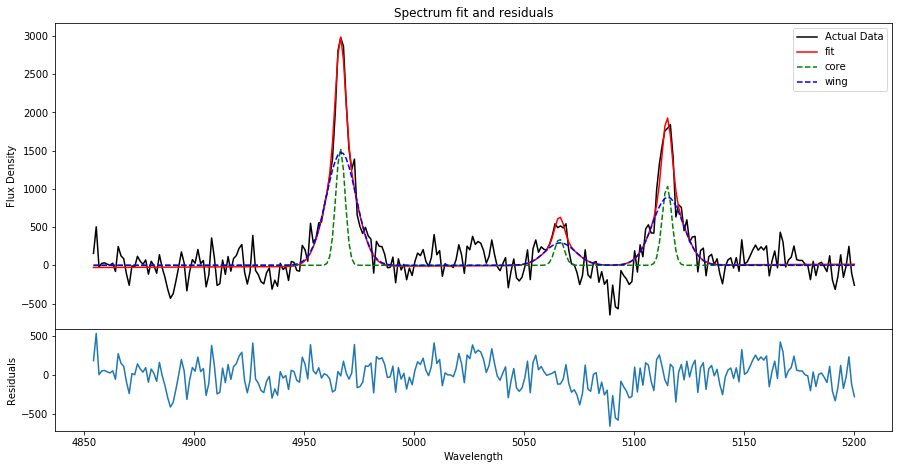

In [8]:
fit = full_gauss3(popt,x,y,y_err)*(y_err)+y
residual = y - fit

plt.figure(figsize=(15,7.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # # set height ratios for sublots

ax1=plt.subplot(gs[0])  # first subplot
ax1.plot(x,y,'-k',label='Actual Data')
ax1.plot(x,fit,'-r',label='fit')

plt.plot(x,Hb_O3_gauss(x,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma),'--g',label='core')
plt.plot(x,Hb_O3_gauss(x,amp_Hb_2,amp_OIII50072,vel_wing,vel_wing_sigma),'--b',label='wing')

plt.title('Spectrum fit and residuals')
plt.ylabel('Flux Density')
plt.legend()

ax2=plt.subplot(gs[1])  # second subplot
plt.plot(x,residual)
plt.subplots_adjust(hspace=0)
plt.xlabel('Wavelength')
plt.ylabel('Residuals')

In [9]:
mini_cube = qso_data[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
mini_cube_error = qso_error[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 22)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 22)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavestart,(wavestart+(wavint*mini_cube.shape[0])),wavint)

In [10]:
#mini_data = qso_data
#mini_error = np.sqrt(qso_error)
mini_data = mini_cube
mini_error = np.sqrt(mini_cube_error)

In [18]:
select = (wave > 4750*k) & (wave < 5090*k)
select2 = (wave > 6552*k) & (wave < 6572*k) 
select3 = (wave > 6750*k) & (wave < 6780*k)
par = np.zeros((4,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((4,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [12]:
# hdu = fits.open('table_3C264_extended_double_gauss.fits')
# central_tab = hdu[1].data
# central_columns = hdu[1].header
     
vel_core = 6490.30564333   
vel_core_sigma = 115.17488468


In [19]:
fixed_parameters = [vel_core,vel_core_sigma]  

def full_gauss(p,wave,data,error,fixed_parameters):
    (amp_Hb_1,amp_OIII50071,m,c)=p
    [vel_core, vel_core_sigma] = fixed_parameters
    narrow_OIII1 = Hb_O3_gauss(wave,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma)
    broad_OIII = 0#Hb_O3_gauss(wave,amp_Hb_2,amp_OIII50072,vel_wing,vel_wing_sigma)
    cont = (wave/1000.0)*m+c
    return (narrow_OIII1+broad_OIII+cont-data)/error

In [20]:
start = time.time()

for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        y = mini_data[:,i,j][select]
        y_err = mini_error[:,i,j][select]
        x = wave[select]
        
        popt,pcov = leastsq(full_gauss,x0=[300,150,-0.001,0.1],args=(x,y,y_err,fixed_parameters),maxfev = 10000000)                                                            
        par[:,i,j] = popt
        
#         model = full_gauss(popt,x,y,y_err,fixed_parameters)*(y_err)+y
#         fitted[:,i,j] = model
        
#         plt.plot(x,y)
#         plt.plot(x,model)
#         plt.show()
        
#         residuals[:,i,j] = mini_data[:,i,j][select] - fitted[:,i,j]

#         Monte_Carlo_loops = 100
#         parameters_MC = np.zeros((len(popt),Monte_Carlo_loops))
        
#         for l in range(Monte_Carlo_loops):
#             iteration_data = np.random.normal(y,y_err)
#             popt_MC,pcov_MC = leastsq(full_gauss,x0=[300,150,-0.001,0.1],args=(x,iteration_data,y_err,fixed_parameters),maxfev = 10000000)                                                            
#             parameters_MC[:,l]=popt_MC
            
#         parameters_err = np.std(parameters_MC,1)
#         err[:,i,j]=parameters_err
        

print("Time elapsed: ", str(time.time() - start))

Time elapsed:  5.532536745071411


In [22]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(par[0,:,:],name='amp_Hb1'))
hdus.append(fits.ImageHDU(par[1,:,:],name='amp_OIII1'))
hdus.append(fits.ImageHDU(par[2,:,:],name='m'))
hdus.append(fits.ImageHDU(par[3,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_45x45_spec_HbO3_test2.fits',overwrite=True)

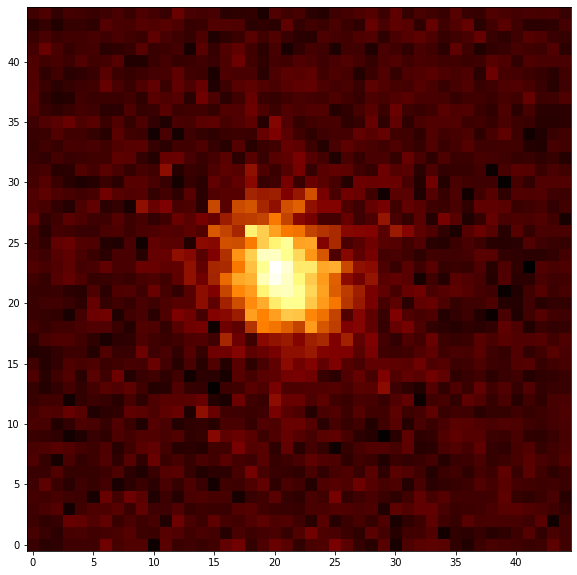

In [24]:
with fits.open('subcube_par_3C264_45x45_spec_HbO3_test2.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Hb1 = hdu[1].data
    OIII1 = hdu[2].data
    #Hb2 = hdu[3].data
    #OIII2 = hdu[4].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(OIII1,cmap='afmhot',origin='lower')

Text(0.5, 1.0, '[OIII]/Hb')

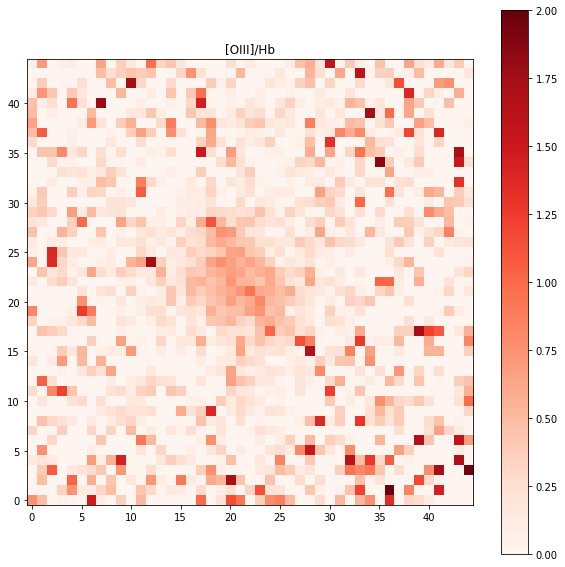

In [35]:
plt.figure(figsize=(10,10))
ratio = OIII1/Hb1
ratio[ratio>2] = 1e-15
ratio[ratio<0] = 1e-15
plt.imshow(ratio,cmap='Reds',origin='lower',interpolation='nearest',vmax=2,vmin=0)
plt.colorbar()
plt.title('[OIII]/Hb')

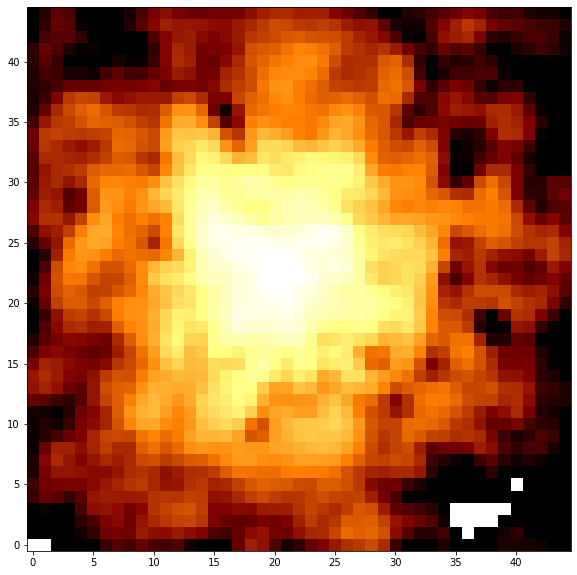

In [52]:
fig=plt.figure(figsize=(10,10))
kernel = Gaussian2DKernel(0.75)
smoothed_data_gauss = convolve(Hb, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=10,vmax=250,norm=LogNorm())

In [27]:
(y0,x0) = ndimage.measurements.maximum_position(Hb1)
print(y0,x0)

# QFitsView says: Image X = 55.672 and Image Y = 57.678

22 19


In [28]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(err[0,:,:],name='amp_Hb_err'))
hdus.append(fits.ImageHDU(err[1,:,:],name='amp_OIII_err'))
hdus.append(fits.ImageHDU(err[2,:,:],name='m'))
hdus.append(fits.ImageHDU(err[3,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_err_45x45_spec_HbO3_100loops.fits',overwrite=True)

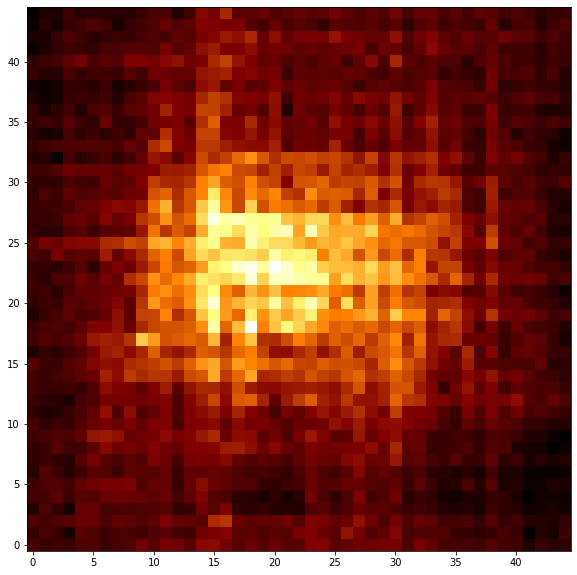

In [29]:
with fits.open('subcube_par_3C264_err_45x45__spec_HbO3_100loops.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Hb_err = hdu[1].data
    OIII_err = hdu[2].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Hb_err,cmap='afmhot',origin='lower')

In [31]:
amp_Hb = par[0,:,:].ravel()
amp_OIII = par[1,:,:].ravel()
m = par[2,:,:].ravel()
c = par[3,:,:].ravel()

amp_Hb_err = err[0,:,:].ravel()
amp_OIII_err = err[1,:,:].ravel()
m_err = err[2,:,:].ravel()
c_err = err[3,:,:].ravel()

In [ ]:
c3 = fits.Column(name='amp_Ha', array=amp_Ha, format='E')
c4 = fits.Column(name='amp_Ha_err', array=amp_Ha_err, format='E')
c5 = fits.Column(name='amp_Ha_br', array=amp_Ha_br, format='E')
c6 = fits.Column(name='amp_Ha_br_err', array=amp_Ha_br_err, format='E')
c7 = fits.Column(name='amp_N6583', array=amp_N6583, format='E')
c8 = fits.Column(name='amp_N6583_err', array=amp_N6583_err, format='E')
c9 = fits.Column(name='amp_N6583_br', array=amp_N6583_br, format='E')
c10 = fits.Column(name='amp_N6583_br_err', array=amp_N6583_br_err, format='E')
c11 = fits.Column(name='amp_S6716', array=amp_S6716, format='E')
c12 = fits.Column(name='amp_S6716_err', array=amp_S6716_err, format='E')
c13 = fits.Column(name='amp_S6716_br', array=amp_S6716_br, format='E')
c14 = fits.Column(name='amp_S6716_br_err', array=amp_S6716_br_err, format='E')
c15 = fits.Column(name='amp_S6731', array=amp_S6731, format='E')
c16 = fits.Column(name='amp_S6731_err', array=amp_S6731_err, format='E')
c17 = fits.Column(name='amp_S6731_br', array=amp_S6731_br, format='E')
c18 = fits.Column(name='amp_S6731_br_err', array=amp_S6731_br_err, format='E')
c19 = fits.Column(name='vel_core', array=vel_core, format='E')
c20 = fits.Column(name='vel_core_err', array=vel_core_err, format='E')
c21 = fits.Column(name='vel_core_sigma', array=vel_core_sigma, format='E')
c22 = fits.Column(name='vel_core_sigma_err', array=vel_core_sigma_err, format='E')
c23 = fits.Column(name='vel_wing', array=vel_wing, format='E')
c24 = fits.Column(name='vel_wing_err', array=vel_wing_err, format='E')
c25 = fits.Column(name='vel_wing_sigma', array=vel_wing_sigma, format='E')
c26 = fits.Column(name='vel_wing_sigma_err', array=vel_wing_sigma_err, format='E')
c27 = fits.Column(name='m', array=m, format='E')
c28 = fits.Column(name='m_err', array=m_err, format='E')
c29 = fits.Column(name='c', array=c, format='E')
c30 = fits.Column(name='c_err', array=c_err, format='E')

t = fits.BinTableHDU.from_columns([c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22,c23,c24,c25,c26,c27,c28,c29,c30])

t.writeto('table_3C264_extended_double_gauss.fits',overwrite=True)